# **Predictive Analysis of Academic Performance Utilizing Study Habits and Prior Achievement Metrics**

In [1]:
# libraries needed in this proposal

library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

## **Introduction**

#### **Relevant background information on the topic**

The paradigm of education has seen a dramatic shift towards web-based learning systems over the past decade. These systems, by virtue of their digital nature, present an opportunity to track and analyze student engagement data in unprecedented ways. The dataset we propose to explore in this study is derived from the research titled “The Development of Intuitive Knowledge Classifier and the Modeling of Domain Dependent Data” conducted by H. Tolga Kahraman et al. (2013). The researchers employed a web-based learning system to track dynamic data, including pages visited by students and time spent on specific concept or goal pages. This data was then utilized to create variables that provide meaningful insights into student behavior and performance, and subsequently, used to classify the knowledge level of the users.

#### **The Question we will try to answer with our project**

Our research aims to delve into this rich dataset to answer a pertinent predictive question: Can we predict a student's knowledge level (UNS) and the exam performance for material (PEG) based on the degree of study time for material (STG), the degree of repetition number for material (SCG), study time for related objects like prerequisites (STR), and the exam performance for related objects (LPR)? Furthermore, we seek to identify the factor that exhibits the strongest correlation with PEG.

#### **The dataset description that will be used to answer the question**

Our primary resources for this research are two comprehensive CSV files: a training dataset and a testing dataset. These datasets feature the following variables: STG (quantitative representation of study time for material), SCG (quantitative measure of repetition number of user for goal object materials), STR (quantitative reflection of study time of user for related objects with goal object), LPR (quantitative measure of exam performance of user for related objects with goal object), PEG (quantitative variable for exam performance for material), and UNS (categorical variable for knowledge level of user). The training dataset comprises 258 entries, and the testing dataset contains 145 entries, both excluding column headers. These datasets will be pivotal in our quest to understand the key determinants of academic performance in a web-based learning environment.

## **Preliminary exploratory data analysis**

#### **Data Acquisition**

In [2]:
# download data from our group's remote repository

url <- "https://raw.githubusercontent.com/stankur/dsci-100-project/main/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.csv"

data <- read_csv(url)

data <- data |> 
        select(STG:UNS)

data

New names:
• `` -> `...7`
• `` -> `...8`
Rows: 258 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): UNS, Attribute Information:
dbl (5): STG, SCG, STR, LPR, PEG
lgl (2): ...7, ...8

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
⋮,⋮,⋮,⋮,⋮,⋮
0.54,0.82,0.71,0.29,0.77,High
0.50,0.75,0.81,0.61,0.26,Middle
0.66,0.90,0.76,0.87,0.74,High


#### **Initial Data Summary (Exploratory Data Analysis)**

In [3]:
# Mean values of quantitative variables
mean_data <- data |>
                mutate(STG = mean(STG),  
                       SCG = mean(SCG), 
                       STR = mean(STR),
                       LPR = mean(LPR),
                       PEG = mean(PEG)) |>
                select(STG, SCG, STR, LPR, PEG) |>
                head(1)

# Checking for missing data
na <- data |> 
            mutate(STG = is.na(STG), SCG = is.na(SCG), 
                   STR = is.na(STR), LPR = is.na(LPR), 
                   PEG = is.na(PEG), UNS = is.na(UNS)) |>
            select(STG, SCG, STR, LPR, PEG, UNS) |>
            head(1)

# Summary of 'UNS' categorical variable
uns_grouped_by_level <- group_by(data, UNS) |>
                        summarize(count = n())

# Transforming data for reporting
mean_tidy <- mean_data |>
        pivot_longer(cols = STG:PEG,
                    names_to = "Feature", values_to = "Mean") 

na_tidy <- na |>
        pivot_longer(na, cols = STG:UNS,
                    names_to = "Feature", values_to = "NA")

tidy <- data.frame("Feature" = c("STG", "SCG", "STR", "LPR", "PEG", "UNS"),
                   "Mean" = c(0.3711473, 0.3556744, 0.4680039, 0.4327132, 0.4585388, "NA"),
                   "Is.NA" = c(FALSE, FALSE, FALSE, FALSE, FALSE, FALSE)) |>
        as_tibble(tidy)

tidy
uns_grouped_by_level

Warning message in gsub(vec_paste0("^", names_prefix), "", cols):
“argument 'pattern' has length > 1 and only the first element will be used”


Feature,Mean,Is.NA
<chr>,<chr>,<lgl>
STG,0.3711473,FALSE
SCG,0.3556744,FALSE
STR,0.4680039,FALSE
LPR,0.4327132,FALSE
PEG,0.4585388,FALSE
UNS,NA,FALSE


UNS,count
<chr>,<int>
High,63
Low,83
Middle,88
very_low,24


#### **Data Visualization**

The first visualization provided is a set of histograms that depict the distribution of numerical variables (STG, SCG, STR, LPR, PEG) in our dataset. Histograms are effective visual aids when we want to understand the distribution of a variable. In each histogram, the x-axis represents the variable's value range and the y-axis represents the frequency of data points within that range.

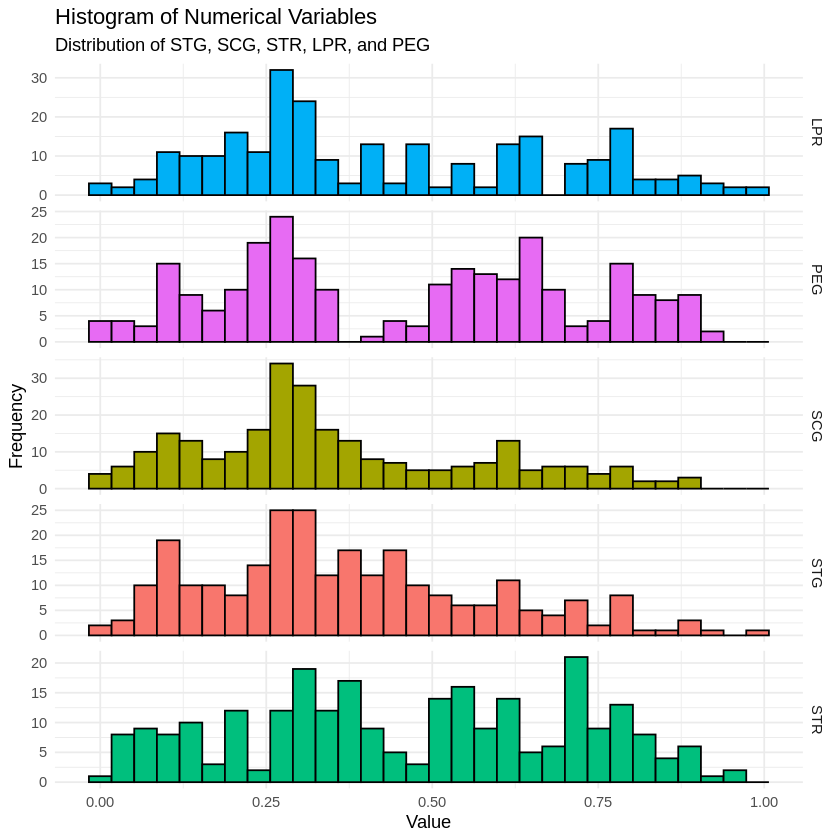

In [4]:
# Selecting numerical columns for visualization
histogrammable_data <- data |> select(STG:PEG)

# Reshaping the data from wide format to long format to facilitate visualization
histogrammable_data_pivoted <- pivot_longer(histogrammable_data, 
                                           cols= STG:PEG,
                                           names_to = "column_name",
                                           values_to ="value")

# Creating a histogram for each numerical variable
quantitative_plot <- ggplot(histogrammable_data_pivoted, aes(x = value, fill = as_factor(column_name))) +
        geom_histogram(bins = 30, color = "black") + 
        facet_grid(rows = vars(column_name), scales = "free_y") + 
        theme_minimal() + 
        labs(fill = "Variable", x = "Value", y = "Frequency", 
             title = "Histogram of Numerical Variables", 
             subtitle = "Distribution of STG, SCG, STR, LPR, and PEG") +
        theme(legend.position = "none") 

quantitative_plot

The subsequent visualization is a bar chart that portrays the distribution of categorical variable UNS (knowledge level) in our dataset. Bar charts are excellent visual tools when we want to compare categorical data. Here, the x-axis enumerates the distinct categories of knowledge level (UNS), and the y-axis quantifies the frequency of each category.

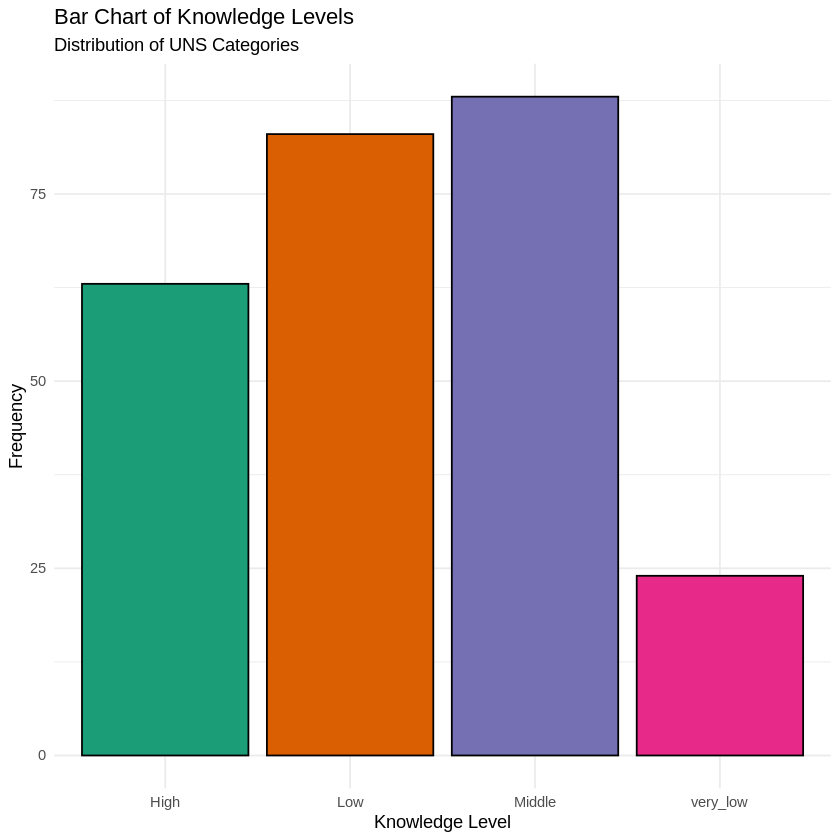

In [5]:
# Organize categories in descending order
uns_grouped_by_level <- uns_grouped_by_level |> 
                        mutate(UNS = factor(UNS, levels = names(sort(table(UNS), decreasing = TRUE))))

# Create bar chart for the categorical variable 'UNS'
uns_bar <- ggplot(uns_grouped_by_level, aes(x=UNS, y=count, fill=UNS)) + 
        geom_bar(stat="identity", color="black") + # outline color for better visual separation
        scale_fill_brewer(palette="Dark2") + # changing the color palette for aesthetic enhancement
        labs(x="Knowledge Level", 
             y="Frequency", 
             title = "Bar Chart of Knowledge Levels", 
             subtitle = "Distribution of UNS Categories", 
             fill="Knowledge Level") +
        theme_minimal() + # applying minimal theme for a cleaner look
        theme(legend.position = "none") # removing legend as it's redundant

uns_bar

## **Methods**

#### **Data Analysis Plan and Chosen Variables**

In our quest to predict the 'UNS' (User Knowledge Level), we plan to adopt a rigorous analytical approach. First, we will calculate the pairwise correlation of all variables present in our dataset. Following this filtration process, we will employ the relevant variables in a k-nearest neighbors model to predict the 'UNS' variable. Additionally, we will implement a linear regression model using 'STG', 'STR', 'LPR', and 'LPR' as independent variables to predict the 'PEG' variable. Our aim here is to identify the variable with the strongest predictive power for 'PEG'.

#### **Visualization of Results**

In order to present a comprehensive and visually intuitive representation of our findings, we plan to use the 'ggpairs' function from the 'GGally' R package. This function allows for the construction of a matrix of scatterplots to compare each pair of variables in our dataset, thus offering an insightful perspective into the relationships and interactions between the variables.

## **Expected Outcomes and Significance**

#### **Expected Findings**

We hypothesize that the variables we have chosen for our models significantly influence the user knowledge level, and consequently, anticipate that our predictive model will have a high degree of accuracy. Moreover, we postulate that the 'LPR' variable, representing the repetition number for the material, will exhibit the most potent influence on exam performance, represented by the 'PEG' variable.

#### **Implications of Findings**

The implications of our anticipated findings are multifold. Primarily, they can guide the development of effective study strategies for students. For instance, if a strong relationship is observed between 'LPR' and 'PEG', it could recommend an emphasis on repetitive learning of basic subject material.

#### **Future Research Questions**

Our study could pave the way for several interesting research questions, including:

- How can the web learning system be optimized to promote superior knowledge growth among users?
- Which metrics (e.g., repetition or study time) should be emphasized for improved learning outcomes?
- Which type of study material (e.g., goal-oriented or related materials) holds the most promise for academic achievement?


## **Reference**

Kahraman, H. T., Sagiroglu, S., & Colak, I. (2013). The development of intuitive knowledge classifier and the modeling of domain dependent data. Knowledge-Based Systems, 37, 283-295. https://doi.org/10.1016/j.knosys.2012.08.009
